# Environment

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
from collections import defaultdict

ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9
ALPHA = 0.1
EPSILON = 0.2
MAX_EPISODES = 500

maze_size = 10
maze = np.zeros((maze_size, maze_size), dtype=int)

walls = [
    (0, 4), (1, 4), (2, 4), (2, 5), (4, 0),
    (4, 1), (4, 2), (5, 2), (9, 5), (8, 5),
    (7, 5), (7, 4), (4, 9), (4, 8), (4, 7), (5, 7)
]
for wall in walls:
    maze[wall] = 1

destinations = [(5, 8), (1, 5), (5, 1), (8, 4)]
agent_colors = ['green', 'blue', 'yellow', 'purple']

#for now the starting points are fixed for the agent
agents = [(1, 1), (8, 1), (8, 8), (1, 8)]

class MultiAgentMazeMinMax:
    def __init__(self, maze, agents, destinations):
        self.maze = maze
        self.agents = agents
        self.destinations = destinations
        self.num_agents = len(agents)
        self.state = tuple(agents)
        self.steps_taken = [0] * self.num_agents

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < maze_size and 0 <= y < maze_size and self.maze[x, y] != 1

    def reset(self):
        self.state = tuple(agents)
        self.steps_taken = [0] * self.num_agents
        return self.state

    def step(self, actions):
      proposed_positions = []
      rewards = []

      for i, action in enumerate(actions):
          current_pos = self.state[i]
          move = ACTIONS[action]
          new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

          # Ensure the move is valid and not to an already occupied square
          if self.is_valid_position(new_pos) and new_pos not in self.state:
              proposed_positions.append(new_pos)
          else:
              proposed_positions.append(current_pos)  # Stay in the current position

      final_positions = list(self.state)
      for i, new_pos in enumerate(proposed_positions):
          # Finalize the positions without allowing collisions
          if proposed_positions.count(new_pos) > 1:
              final_positions[i] = self.state[i]  # Revert to current position if conflict
          else:
              final_positions[i] = new_pos

      next_state = tuple(final_positions)
      for i, new_pos in enumerate(next_state):
          if new_pos == self.destinations[i]:
              reward = 10
          else:
              reward = -1  # Small penalty for every step not at the destination
          rewards.append(reward)

      self.state = next_state
      done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
      for i in range(self.num_agents):
          self.steps_taken[i] += 1

      max_time = max(self.steps_taken)
      return self.state, rewards, done, max_time


# Q-Learning Model

In [20]:
def train_agents_minmax_with_rewards(maze_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(maze_env.num_agents)]
    min_max_time = float('inf')
    episode_rewards = []

    for episode in range(MAX_EPISODES):
        state = maze_env.reset()
        done = False
        total_rewards = 0

        while not done:
            actions = []
            for i in range(maze_env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)

            next_state, rewards, done, max_time = maze_env.step(actions)

            for i in range(maze_env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            total_rewards += sum(rewards)
            state = next_state

        episode_rewards.append(total_rewards)
        min_max_time = min(min_max_time, max_time)

    return q_tables, min_max_time, episode_rewards


# Getting the Optimal path

In [21]:
def get_optimal_paths(maze_env, q_tables):
    optimal_paths = []
    for i in range(maze_env.num_agents):
        state = agents[i]
        path = [state]

        while state != destinations[i]:
            action = np.argmax(q_tables[i][state])
            move = ACTIONS[action]
            next_state = (state[0] + move[0], state[1] + move[1])

            if not maze_env.is_valid_position(next_state):
                break

            path.append(next_state)
            state = next_state

        optimal_paths.append(path)
    return optimal_paths

# Visualisating the Path

In [22]:
def plot_maze_with_paths(maze, agents, destinations, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, maze_size)
    ax.set_ylim(0, maze_size)

    for x in range(maze_size):
        for y in range(maze_size):
            if maze[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, maze_size - x - 1), 1, 1, color='gray'))

    for agent_index, (x, y) in enumerate(agents):
        color = agent_colors[agent_index]
        ax.add_patch(patches.Rectangle((y, maze_size - x - 1), 1, 1, color=color, alpha=0.5))

    for dest_index, (x, y) in enumerate(destinations):
        color = agent_colors[dest_index]
        ax.plot(
            y + 0.5, maze_size - x - 1 + 0.5,
            marker='+', color=color, markersize=20, markeredgewidth=3
        )

    for agent_index, path in enumerate(paths):
        color = agent_colors[agent_index]
        for j in range(1, len(path)):
            x1, y1 = path[j - 1]
            x2, y2 = path[j]
            ax.plot(
                [y1 + 0.5, y2 + 0.5],
                [maze_size - x1 - 1 + 0.5, maze_size - x2 - 1 + 0.5],
                color=color, linewidth=2, linestyle='--'
            )

    for i in range(maze_size + 1):
        ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Grid World Environment with Optimal Paths", fontsize=16)


# Main

Training completed! Minimum maximum time taken by any agent: 15
Optimal paths for agents:
Green: [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (5, 6), (6, 6), (6, 7), (6, 8), (5, 8)]
Blue: [(8, 1), (7, 1), (7, 2), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (4, 5), (4, 6), (3, 6), (2, 6), (1, 6), (1, 5)]
Yellow: [(8, 8), (7, 8), (7, 7), (7, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]
Purple: [(1, 8), (2, 8), (2, 7), (2, 6), (3, 6), (3, 5), (3, 4), (4, 4), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


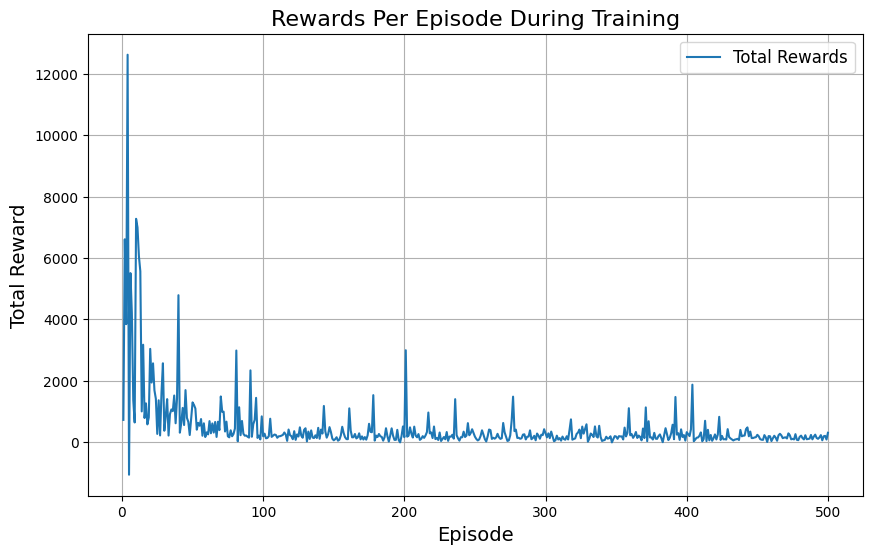

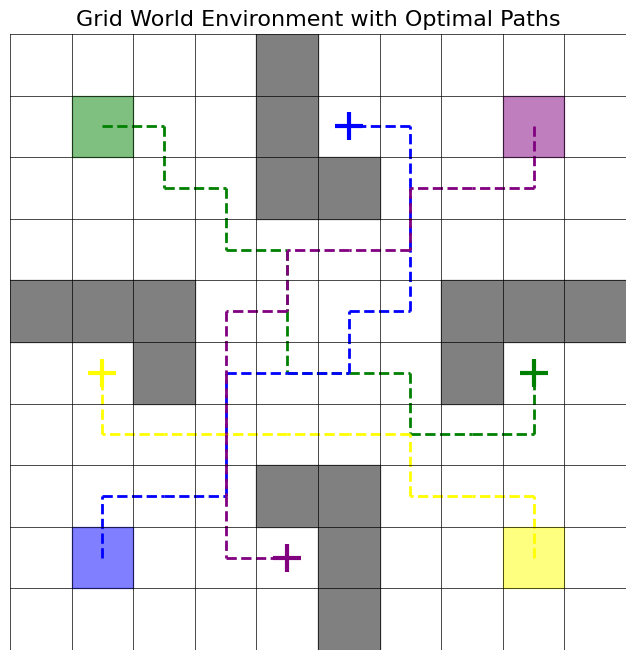

In [23]:
if __name__ == "__main__":
    env = MultiAgentMazeMinMax(maze, agents, destinations)

    q_tables, min_max_time, episode_rewards = train_agents_minmax_with_rewards(env)
    print(f"Training completed! Minimum maximum time taken by any agent: {min_max_time}")
    Agents = ['Green', 'Blue', 'Yellow', 'Purple']
    paths = get_optimal_paths(env, q_tables)
    print("Optimal paths for agents:")
    for i, path in enumerate(paths):
        print(f"{Agents[i]}: {path}")


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, MAX_EPISODES + 1), episode_rewards, label="Total Rewards")
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    plt.title("Rewards Per Episode During Training", fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()
    plot_maze_with_paths(maze, agents, destinations, paths)
    plt.show()


# Randomising the Agent starting points (Bonus Question)

In [43]:
def random_agent_positions(num_agents, maze, destinations):
    positions = []
    while len(positions) < num_agents:
        pos = (random.randint(0, maze_size - 1), random.randint(0, maze_size - 1))
        if pos not in positions and pos not in walls and pos not in destinations:
            positions.append(pos)
    return positions



In [44]:
class MultiAgentMazeMinMax:
    def __init__(self, maze, agents, destinations):
        self.maze = maze
        self.agents = random_agent_positions(len(destinations), maze, destinations) #The random agent for each run
        self.destinations = destinations
        self.num_agents = len(random_agent_positions(len(destinations), maze, destinations))
        self.state = tuple(random_agent_positions(len(destinations), maze, destinations))
        self.steps_taken = [0] * self.num_agents

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < maze_size and 0 <= y < maze_size and self.maze[x, y] != 1

    def reset(self):
        self.state = tuple(random_agent_positions(len(destinations), maze, destinations))
        self.steps_taken = [0] * self.num_agents
        return self.state

    def step(self, actions):
        proposed_positions = []
        rewards = []
        collisions = set()

        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if not self.is_valid_position(new_pos) or new_pos in self.state:
                new_pos = current_pos
            proposed_positions.append(new_pos)

        final_positions = list(self.state)
        for i, new_pos in enumerate(proposed_positions):
            if proposed_positions.count(new_pos) > 1:
                collisions.add(new_pos)
                final_positions[i] = self.state[i]
            else:
                final_positions[i] = new_pos

        next_state = tuple(final_positions)
        for i, new_pos in enumerate(next_state):
            if new_pos == self.destinations[i]:
                reward = 10
            elif new_pos in collisions:
                reward = -10
            else:
                reward = -1
            rewards.append(reward)

        self.state = next_state
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        for i in range(self.num_agents):
            self.steps_taken[i] += 1

        max_time = max(self.steps_taken)
        return self.state, rewards, done, max_time

Training completed! Minimum maximum time taken by any agent: 7
Optimal paths for agents:
Green: [(4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (5, 8)]
Blue: [(3, 6), (2, 6), (1, 6), (1, 5)]
Yellow: [(3, 5), (3, 4), (3, 3), (4, 3), (5, 3), (6, 3), (6, 2), (6, 1), (5, 1)]
Purple: [(3, 9), (3, 8), (3, 7), (3, 6), (4, 6), (4, 5), (5, 5), (6, 5), (6, 4), (6, 3), (7, 3), (8, 3), (8, 4)]


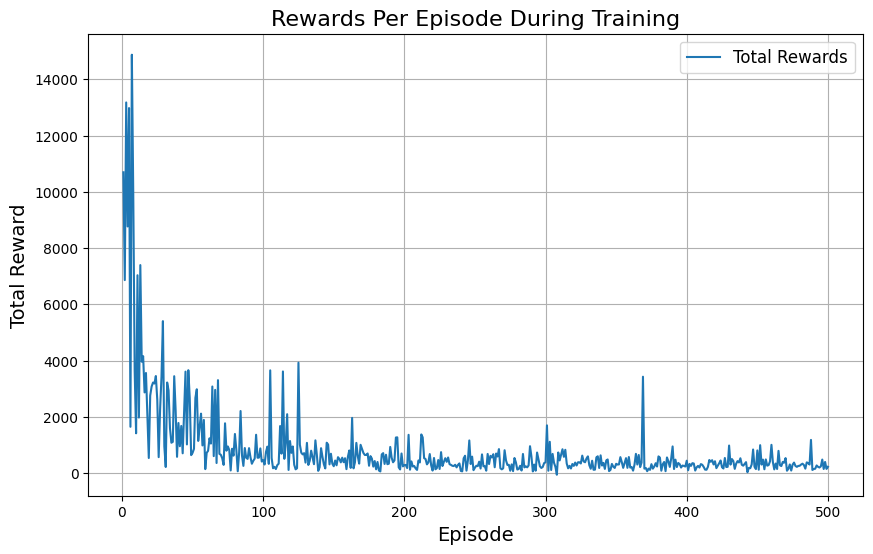

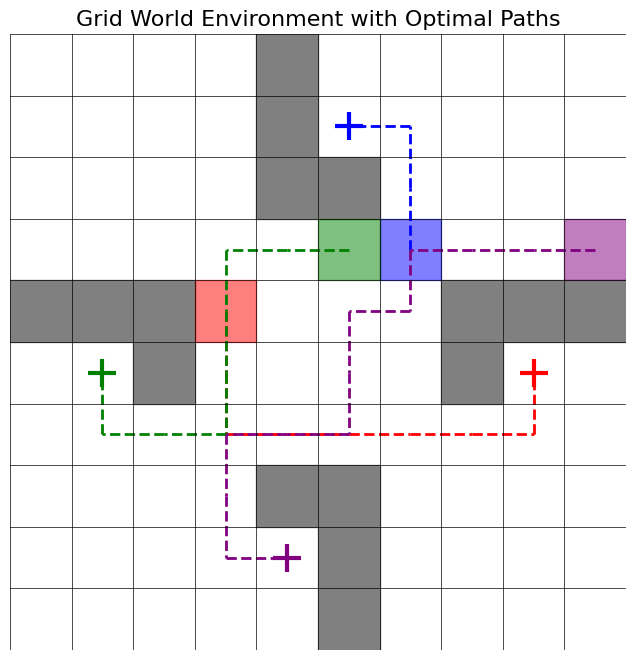

In [45]:
if __name__ == "__main__":
    agents = random_agent_positions(len(destinations), maze, destinations)
    env = MultiAgentMazeMinMax(maze, agents, destinations)

    q_tables, min_max_time, episode_rewards = train_agents_minmax_with_rewards(env)
    print(f"Training completed! Minimum maximum time taken by any agent: {min_max_time}")
    Agents = ['Green', 'Blue', 'Yellow', 'Purple']
    paths = get_optimal_paths(env, q_tables)
    print("Optimal paths for agents:")
    for i, path in enumerate(paths):
        print(f"{Agents[i]}: {path}")


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, MAX_EPISODES + 1), episode_rewards, label="Total Rewards")
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    plt.title("Rewards Per Episode During Training", fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()
    plot_maze_with_paths(maze, agents, destinations, paths)
    plt.show()
